In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn.functional as F
import sklearn
import cv2
import numpy as np
import os
import pydicom
import SimpleITK as sitk
import matplotlib.pyplot as plt
import re
from skimage.transform import resize
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import time
import random
from scipy.ndimage import rotate
import albumentations as A
from sklearn.model_selection import KFold



In [3]:
print("Is CUDA available:", torch.cuda.is_available())  # Vérifie si CUDA est disponible pour l'accélération GPU
print("cuDNN version:", torch.backends.cudnn.version())  # Affiche la version de cuDNN utilisée par PyTorch


Is CUDA available: True
cuDNN version: 90600


In [ ]:
# Import dataset with updated paths
img_path = "/voletu/users/zhangnin/CODE/transfer_31361_files_9f28c4e7/tab_img3D_320_native_recad-dyn.npy"#chemin des donnée img
seg_path = "/voletu/users/zhangnin/CODE/transfer_31361_files_9f28c4e7/tab_seg3D_320_native_recad-dyn.npy"#chemin des donnée seg
dataset_img = np.load(img_path, allow_pickle=True)
dataset_seg = np.load(seg_path, allow_pickle=True)

# Define output paths for augmented data
aug_img_path = "/voletu/users/zhangnin/CODE/transfer_31361_files_9f28c4e7/tab_img3D_320_augmented.npy"#crée votre chemin
aug_seg_path = "/voletu/users/zhangnin/CODE/transfer_31361_files_9f28c4e7/tab_seg3D_320_augmented.npy"

In [ ]:
#Data augmentation partie
def identity(image, segmentation):
    """
    Fonction d'identité qui ne modifie pas l'image et la segmentation.
    
    """
    return image, segmentation

def rotate_image(image, angle=15):
    """
    Effectue une rotation de l'image.

    Paramètres :
    - image : np.ndarray, image d'entrée.
    - angle : float, angle de rotation en degrés (par défaut 15°).

    Retour :
    - np.ndarray, image après rotation.
    """
    return rotate(image, angle, reshape=False, mode='constant', cval=0, order=1)

def rotate_segmentation(segmentation, angle=15):
    """
    Effectue une rotation sur la segmentation.

    Paramètres :
    - segmentation : np.ndarray, masque de segmentation.
    - angle : float, angle de rotation en degrés (par défaut 15°).

    Retour :
    - np.ndarray, masque de segmentation après rotation.
    """
    return rotate(segmentation, angle, reshape=False, mode='constant', cval=0, order=0).astype(np.uint8)

def add_noise(image, var=0.02):
    """
    Ajoute du bruit gaussien à l'image.

    Paramètres :
    - image : np.ndarray, image d'entrée.
    - var : float, variance du bruit ajouté (par défaut 0.02).

    Retour :
    - np.ndarray, image bruitée.
    """
    image = image.astype(np.float32)
    max_val = image.max()

    if max_val > 1.0:
        image = image / 255.0  # Normalisation si nécessaire

    noise = np.random.normal(0, np.sqrt(var), image.shape)  # Génération du bruit gaussien

    noisy_image = np.clip(image + noise, 0, 1)  # Limitation des valeurs dans [0,1]

    if max_val > 1.0:
        noisy_image = (noisy_image * 255).astype(np.uint8)
    else:
        noisy_image = noisy_image.astype(np.float32)

    return noisy_image

def flip_image(image, axis=0):
    """
    Effectue une symétrie horizontale ou verticale sur l'image.

    Paramètres :
    - image : np.ndarray, image d'entrée.
    - axis : int, axe de symétrie (0 = vertical, 1 = horizontal, par défaut 0).

    Retour :
    - np.ndarray, image symétrique.
    """
    return np.flip(image, axis=axis)

def flip_segmentation(segmentation, axis=0):
    """
    Effectue une symétrie horizontale ou verticale sur la segmentation.

    Paramètres :
    - segmentation : np.ndarray, masque de segmentation.
    - axis : int, axe de symétrie (0 = vertical, 1 = horizontal, par défaut 0).

    Retour :
    - np.ndarray, segmentation symétrique.
    """
    return np.flip(segmentation, axis=axis)

def adjust_contrast(image, alpha=1.5, beta=0):
    """
    Ajuste le contraste de l'image.

    Paramètres :
    - image : np.ndarray, image d'entrée.
    - alpha : float, facteur de contraste (>1 augmente, <1 diminue).
    - beta : float, facteur d'ajustement de la luminosité.

    Retour :
    - np.ndarray, image avec contraste ajusté.
    """
    return np.clip(alpha * image + beta, 0, 1)

def gamma_correction(image, gamma=1.5):
    """
    Applique une correction gamma sur l'image.

    Paramètres :
    - image : np.ndarray, image d'entrée.
    - gamma : float, valeur du gamma (1.5 par défaut, >1 éclaircit, <1 assombrit).

    Retour :
    - np.ndarray, image après correction gamma.
    """
    if image.max() > 1.0:
        image = image / 255.0  # Normalisation si nécessaire

    invGamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** invGamma * 255 for i in range(256)]).astype("uint8")

    return cv2.LUT((image * 255).astype(np.uint8), table).astype(np.float32) / 255.0

def affine_transform(image, segmentation):
    """
    Applique une transformation affine sur l'image et la segmentation.

    Paramètres :
    - image : np.ndarray, image d'entrée.
    - segmentation : np.ndarray, masque de segmentation associé.

    Retour :
    - np.ndarray, image transformée.
    - np.ndarray, segmentation transformée.
    """
    transform = A.Affine(scale=(0.95, 1.05), rotate=(-10, 10), translate_percent=(-0.05, 0.05), always_apply=True)
    transformed = transform(image=image, mask=segmentation)
    return transformed['image'], transformed['mask']

def random_cutout(image, segmentation, num_holes=6, hole_size=10, ignore_label=255):
    """
    Applique la technique "Cutout" en masquant certaines zones de l'image et de la segmentation.

    Paramètres :
    - image : np.ndarray, image d'entrée.
    - segmentation : np.ndarray, masque de segmentation.
    - num_holes : int, nombre de trous aléatoires à générer (6 par défaut).
    - hole_size : int, taille de chaque trou en pixels (10 par défaut).
    - ignore_label : int, valeur à attribuer aux pixels masqués dans la segmentation.

    Retour :
    - np.ndarray, image avec cutout appliqué.
    - np.ndarray, segmentation avec cutout appliqué.
    """
    h, w = image.shape
    mask = np.ones((h, w), np.float32)
    seg_mask = np.ones((h, w), np.uint8) * ignore_label 

    for _ in range(num_holes):
        y = random.randint(0, h - hole_size)
        x = random.randint(0, w - hole_size)
        mask[y:y + hole_size, x:x + hole_size] = 0
        seg_mask[y:y + hole_size, x:x + hole_size] = 0

    return image * mask, np.where(segmentation > 0, segmentation * mask, seg_mask)


In [6]:
# Define available augmentations
augmentations = {
    "identity": lambda img, seg: (identity(img, seg)),
    "rotate": lambda img, seg: (rotate_image(img, angle=15), rotate_segmentation(seg, angle=15)),
    "noise": lambda img, seg: (add_noise(img, var=0.02), seg),
    "flip": lambda img, seg: (flip_image(img, axis=0), flip_segmentation(seg, axis=0)),
    "contrast": lambda img, seg: (adjust_contrast(img, alpha=1.5), seg),
    "gamma": lambda img, seg: (gamma_correction(img, gamma=1.5), seg),
    "affine": lambda img, seg: affine_transform(img, seg),
    "cutout": lambda img, seg: (random_cutout(img, num_holes=6, hole_size=10), seg)
}

# Apply augmentation
aug_dataset_img, aug_dataset_seg = [], []

total_original_volumes = len(dataset_img)
total_original_slices = sum(vol.shape[0] for vol in dataset_img)

total_final_volumes = 0
total_final_slices = 0

for vol_img, vol_seg in zip(dataset_img, dataset_seg):
    aug_vol_img, aug_vol_seg = [], []
    
    for slice_idx in range(vol_img.shape[0]):
        img, seg = vol_img[slice_idx], vol_seg[slice_idx]
        


        #Choisissez votre type d'enrichissement des données
        selected_aug = "rotate"
        
        
        
        
        img_aug, seg_aug = augmentations[selected_aug](img, seg)

        aug_vol_img.append(img_aug)
        aug_vol_seg.append(seg_aug)
    
    aug_dataset_img.append(vol_img)  # Store original volume
    aug_dataset_seg.append(vol_seg)  # Store original segmentation
    aug_dataset_img.append(np.array(aug_vol_img))  # Store augmented volume
    aug_dataset_seg.append(np.array(aug_vol_seg))  # Store augmented segmentation

# Calculate final dataset size
total_final_volumes = len(aug_dataset_img)
total_final_slices = sum(vol.shape[0] for vol in aug_dataset_img)

# Save augmented dataset to a new location
dataset_img_aug = np.array(aug_dataset_img, dtype=object)
dataset_seg_aug = np.array(aug_dataset_seg, dtype=object)
np.save(aug_img_path, dataset_img_aug)
np.save(aug_seg_path, dataset_seg_aug)

# Display dataset statistics
print(f"Total original MRI volumes: {total_original_volumes}")
print(f"Total original MRI slices: {total_original_slices}")
print(f"Total final MRI volumes (after augmentation): {total_final_volumes}")
print(f"Total final MRI slices (after augmentation): {total_final_slices}")

Total original MRI volumes: 40
Total original MRI slices: 3488
Total final MRI volumes (after augmentation): 80
Total final MRI slices (after augmentation): 6976


In [8]:
print(np.unique(dataset_seg[1]))

[0. 1.]


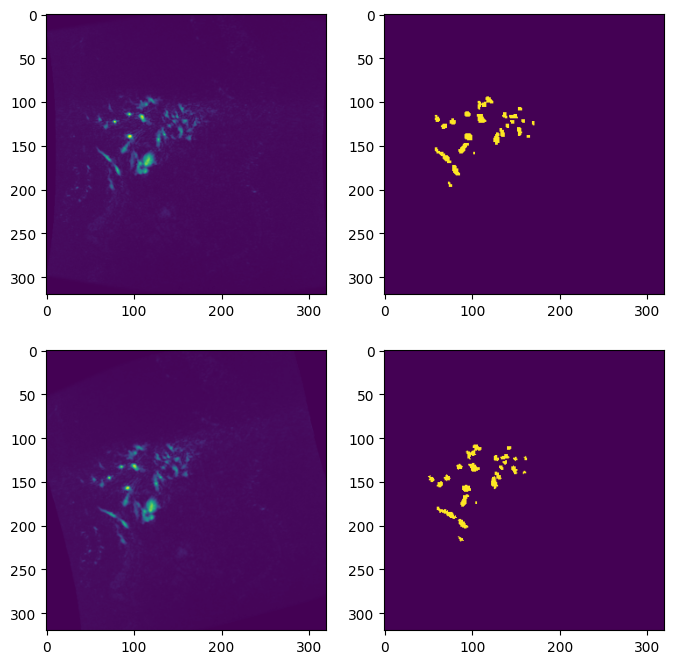

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(221)
plt.imshow(dataset_img[39][20])# Première image : image originale
plt.subplot(222)
plt.imshow(dataset_seg[39][20])# Deuxième image : segmentation originale
plt.subplot(223)
plt.imshow(dataset_img_aug[79][20])# Troisième image : image après augmentation
plt.subplot(224)
plt.imshow(dataset_seg_aug[79][20])# Quatrième image : segmentation après augmentation
plt.show()

In [ ]:
# Créer le chemin de sauvegarde
save_path = "/voletu/users/zhangnin/CODE/data/Folds_native_recad-dyn/"
os.makedirs(save_path, exist_ok=True)

# Validation croisée KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Données originales et augmentées
original_inputs = dataset_img  # 40 ensembles originaux
original_targets = dataset_seg
augmented_inputs = dataset_img_aug  # 80 ensembles augmentés
augmented_targets = dataset_seg_aug

for fold_no, (train_idx, test_idx) in enumerate(kfold.split(original_inputs, original_targets), 1):
    print('------------------------------------------------------------------------')
    print(f'Entraînement pour le fold {fold_no} ...')

    # Jeu d'entraînement : inclut les données augmentées correspondantes aux données originales
    X_train = [augmented_inputs[i] for i in train_idx] + [augmented_inputs[40 + i] for i in train_idx]
    y_train = [augmented_targets[i] for i in train_idx] + [augmented_targets[40 + i] for i in train_idx]

    # Jeu de test : uniquement les données originales
    X_test = [original_inputs[i] for i in test_idx]
    y_test = [original_targets[i] for i in test_idx]

    # Conversion en tableaux numpy
    X_train = np.array(X_train, dtype=object)
    y_train = np.array(y_train, dtype=object)
    X_test = np.array(X_test, dtype=object)
    y_test = np.array(y_test, dtype=object)

    # Sauvegarde des données
    np.save(f"{save_path}{fold_no}_X_train.npy", X_train)
    np.save(f"{save_path}{fold_no}_y_train.npy", y_train)
    np.save(f"{save_path}{fold_no}_X_test.npy", X_test)
    np.save(f"{save_path}{fold_no}_y_test.npy", y_test)

    print(f"Fold {fold_no} - forme de X_train : {X_train.shape}, forme de X_test : {X_test.shape}")


------------------------------------------------------------------------
Training for fold 1 ...
Fold 1 - X_train shape: (64,), X_test shape: (8,)
------------------------------------------------------------------------
Training for fold 2 ...
Fold 2 - X_train shape: (64,), X_test shape: (8,)
------------------------------------------------------------------------
Training for fold 3 ...
Fold 3 - X_train shape: (64,), X_test shape: (8,)
------------------------------------------------------------------------
Training for fold 4 ...
Fold 4 - X_train shape: (64,), X_test shape: (8,)
------------------------------------------------------------------------
Training for fold 5 ...
Fold 5 - X_train shape: (64,), X_test shape: (8,)


In [ ]:
"""
Ensemble d'entraînement 
Il y a 80 ensembles d'images IRM augmentées (2 versions augmentées pour chaque échantillon original).
Avec la validation croisée en 5 folds, chaque fold utilise 80 × 4/5 = 64 ensembles pour l'entraînement.

Ensemble de test 
L'ensemble de test utilise uniquement les 40 images IRM originales.
Pour chaque fold, 40 × 1/5 = 8 images originales sont utilisées pour le test.
"""
y_train = np.load("/voletu/users/zhangnin/CODE/data/Folds_native_recad-dyn/2_y_train.npy",allow_pickle=True)
y_test = np.load("/voletu/users/zhangnin/CODE/data/Folds_native_recad-dyn/2_y_test.npy",allow_pickle=True)
X_train = np.load("/voletu/users/zhangnin/CODE/data/Folds_native_recad-dyn/2_X_train.npy",allow_pickle=True)
X_test = np.load("/voletu/users/zhangnin/CODE/data/Folds_native_recad-dyn/2_X_test.npy",allow_pickle=True)

print(y_train.shape)
print(y_test.shape)
print(X_train.shape)
print(X_test.shape)         

(64,)
(8,)
(64,)
(8,)


In [ ]:
import numpy as np
import torch
import os

# Chemin des données
base_path = "/voletu/users/zhangnin/CODE/data/Folds_native_recad-dyn/"

# Fonction pour convertir des volumes 3D en tranches 2D
def convert_to_2D(data_list):
    """Convertit un volume 3D (num_slices, 320, 320) en tranches 2D (total_slices, 320, 320)."""
    return np.concatenate(data_list, axis=0)

# Traitement des données pour chaque Fold
for fold_no in range(1, 6):  # Validation croisée à 5 folds
    print(f"\n=== Traitement des données pour le Fold {fold_no} ===")

    # 1. Chargement des ensembles d'entraînement et de test originaux
    X_train = np.load(f"{base_path}{fold_no}_X_train.npy", allow_pickle=True)
    y_train = np.load(f"{base_path}{fold_no}_y_train.npy", allow_pickle=True)
    X_test = np.load(f"{base_path}{fold_no}_X_test.npy", allow_pickle=True)
    y_test = np.load(f"{base_path}{fold_no}_y_test.npy", allow_pickle=True)

    print(f"Chargé : X_train {X_train.shape}, y_train {y_train.shape}, X_test {X_test.shape}, y_test {y_test.shape}")

    # 2. Conversion des volumes 3D en tranches 2D
    X_train_2D = convert_to_2D(X_train)
    y_train_2D = convert_to_2D(y_train)
    X_test_2D = convert_to_2D(X_test)
    y_test_2D = convert_to_2D(y_test)

    print(f"3D en 2D : X_train_2D {X_train_2D.shape}, X_test_2D {X_test_2D.shape}")

    # 3. Ajout d'une dimension de canal (N, H, W) → (N, H, W, 1)
    X_train_exp = np.expand_dims(X_train_2D, axis=-1)
    y_train_exp = np.expand_dims(y_train_2D, axis=-1)
    X_test_exp = np.expand_dims(X_test_2D, axis=-1)
    y_test_exp = np.expand_dims(y_test_2D, axis=-1)

    # 4. Normalisation (0-255 → 0-1)
    X_train_exp = X_train_exp.astype(np.float32)
    X_test_exp = X_test_exp.astype(np.float32)
    y_train_exp = y_train_exp.astype(np.float32)
    y_test_exp = y_test_exp.astype(np.float32)

    # 5. Réorganisation des dimensions (N, H, W, 1) → (N, 1, H, W)
    X_train_final = np.transpose(X_train_exp, (0, 3, 1, 2))
    y_train_final = np.transpose(y_train_exp, (0, 3, 1, 2))
    X_test_final = np.transpose(X_test_exp, (0, 3, 1, 2))
    y_test_final = np.transpose(y_test_exp, (0, 3, 1, 2))

    print(f"Dimensions finales : X_train {X_train_final.shape}, X_test {X_test_final.shape}")

    # 6. Conversion en tenseurs PyTorch
    X_train_tensor = torch.tensor(X_train_final)
    y_train_tensor = torch.tensor(y_train_final)
    X_test_tensor = torch.tensor(X_test_final)
    y_test_tensor = torch.tensor(y_test_final)

    print(f"Tenseurs PyTorch : X_train {X_train_tensor.shape}, X_test {X_test_tensor.shape}")

    # 7. Sauvegarde des fichiers traités
    np.save(f"{base_path}{fold_no}_X_train_2D.npy", X_train_final)
    np.save(f"{base_path}{fold_no}_y_train_2D.npy", y_train_final)
    np.save(f"{base_path}{fold_no}_X_test_2D.npy", X_test_final)
    np.save(f"{base_path}{fold_no}_y_test_2D.npy", y_test_final)

    print(f"✅ Traitement du Fold {fold_no} terminé, sauvegardé au format 2D.\n")


In [20]:
def dice_coefficient(y_true, y_pred, smooth=1):

    # Aplatir le tenseur
    y_true_f = y_true.contiguous().view(-1)
    y_pred_f = y_pred.contiguous().view(-1)
    # Calculer l'intersection
    intersection = torch.sum(y_true_f * y_pred_f)
    # Calculer le coefficient de Dice
    score = (2. * intersection + smooth) / (torch.sum(y_true_f) + torch.sum(y_pred_f) + smooth)
    return score

def dice_bce_loss(y_pred, y_true, alpha=0.5):

    # Calculer la perte d'entropie croisée binaire
    bce = F.binary_cross_entropy(y_pred, y_true)
    # Calculer la perte de Dice
    dice_loss = 1 - dice_coefficient(y_true, y_pred)
    # Combinaison pondérée
    return alpha * bce + (1 - alpha) * dice_loss


In [ ]:
# Bloc de double convolution utilise pytorch
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.conv(x)

# Bloc encodeur
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.conv = ConvBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    
    def forward(self, x):
        x = self.conv(x)
        p = self.pool(x)
        return x, p

# Bloc décodeur
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = ConvBlock(out_channels * 2, out_channels)
    
    def forward(self, x, skip_features):
        x = self.up(x)
        # Ajustement si les tailles ne correspondent pas
        if x.shape != skip_features.shape:
            x = F.interpolate(x, size=skip_features.shape[2:])
        x = torch.cat([x, skip_features], dim=1)
        x = self.conv(x)
        return x


class UNet(nn.Module):
    def __init__(self, in_channels, n_classes):
        super(UNet, self).__init__()
        # Partie encodeur
        self.enc1 = EncoderBlock(in_channels, 64)
        self.enc2 = EncoderBlock(64, 128)
        self.enc3 = EncoderBlock(128, 256)
        self.enc4 = EncoderBlock(256, 512)
        
        # Partie pont (Bridge)
        self.bottleneck = ConvBlock(512, 1024)
        
        # Partie décodeur
        self.dec1 = DecoderBlock(1024, 512)
        self.dec2 = DecoderBlock(512, 256)
        self.dec3 = DecoderBlock(256, 128)
        self.dec4 = DecoderBlock(128, 64)
        
        self.final_conv = nn.Conv2d(64, n_classes, kernel_size=1, padding=0)
        
        # Choix de la fonction d'activation en fonction de n_classes
        if n_classes == 1:
            self.activation = nn.Sigmoid()
            print("sigmoid")
        else:
            self.activation = nn.Softmax(dim=1)
            print("softmax")
    
    def forward(self, x):
        # Encodeur
        s1, p1 = self.enc1(x)  
        s2, p2 = self.enc2(p1)
        s3, p3 = self.enc3(p2)
        s4, p4 = self.enc4(p3)
        
        # Pont (Bridge)
        b1 = self.bottleneck(p4)
        
        # Décodeur
        d1 = self.dec1(b1, s4)
        d2 = self.dec2(d1, s3)
        d3 = self.dec3(d2, s2)
        d4 = self.dec4(d3, s1)
        
        outputs = self.final_conv(d4)
        outputs = self.activation(outputs)
        return outputs


In [23]:
data_path = "/voletu/users/zhangnin/CODE/data/Folds_native_recad-dyn/"
base_path = "/voletu/users/zhangnin/CODE/data/results_bce_dice_0.5/"
if not os.path.exists(base_path):
    os.makedirs(base_path)

fold_no = 4  # Numéro actuel du fold

print(f"Loading preprocessed 2D datasets for fold {fold_no}...")
X_train = np.load(os.path.join(data_path, f"{fold_no}_X_train_2D.npy"))
y_train = np.load(os.path.join(data_path, f"{fold_no}_y_train_2D.npy"))
X_test = np.load(os.path.join(data_path, f"{fold_no}_X_test_2D.npy"))
y_test = np.load(os.path.join(data_path, f"{fold_no}_y_test_2D.npy"))

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=1, n_classes=1).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Construction du jeu de données et du DataLoader
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset   = TensorDataset(X_test_tensor, y_test_tensor)
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader    = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

num_epochs = 100
patience = 10  # Arrêt anticipé si la perte de validation ne diminue pas pendant 'patience' epochs consécutifs
best_val_loss = float('inf')
epochs_no_improve = 0

# Stockage des métriques pour chaque epoch
train_loss_history = []
val_loss_history = []
train_dice_history = []
val_dice_history = []

# Ouvrir un fichier journal pour enregistrer les informations du processus d'entraînement
log_filename = os.path.join(base_path, f"training_fold_{fold_no}.log")
log_file = open(log_filename, "w")

for epoch in range(num_epochs):
    # Afficher un en-tête pour chaque nouvel epoch (similaire à la sortie de Keras)
    if epoch > 0:
        epoch_header = f"Epoch {epoch+1}/{num_epochs}"
        print(epoch_header)
        log_file.write(epoch_header + "\n")
    
    model.train()
    epoch_start = time.time()
    train_loss_total = 0.0
    train_dice_total = 0.0
    num_batches = len(train_loader)
    
    # Phase d'entraînement
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = dice_bce_loss(outputs, targets, alpha=0.5)
        loss.backward()
        optimizer.step()
        
        train_loss_total += loss.item() * inputs.size(0)
        train_dice_total += dice_coefficient(targets, outputs).item() * inputs.size(0)
    
    epoch_time = time.time() - epoch_start
    train_loss_epoch = train_loss_total / len(train_dataset)
    train_dice_epoch = train_dice_total / len(train_dataset)
    avg_ms_per_step = (epoch_time / num_batches) * 1000  # Temps moyen par étape (millisecondes)
    
    # Phase de validation
    model.eval()
    val_loss_total = 0.0
    val_dice_total = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = dice_bce_loss(outputs, targets, alpha=0.5)
            val_loss_total += loss.item() * inputs.size(0)
            val_dice_total += dice_coefficient(targets, outputs).item() * inputs.size(0)
    val_loss_epoch = val_loss_total / len(val_dataset)
    val_dice_epoch = val_dice_total / len(val_dataset)
    
    # Enregistrement des métriques pour cet epoch
    train_loss_history.append(train_loss_epoch)
    train_dice_history.append(train_dice_epoch)
    val_loss_history.append(val_loss_epoch)
    val_dice_history.append(val_dice_epoch)
    
    # Générer une ligne de sortie similaire à Keras
    summary_line = (f"{num_batches}/{num_batches} [==============================] - {int(epoch_time)}s "
                    f"{int(avg_ms_per_step)}ms/step - loss: {train_loss_epoch:.4f} - "
                    f"dice_coefficient: {train_dice_epoch:.4f} - val_loss: {val_loss_epoch:.4f} - "
                    f"val_dice_coefficient: {val_dice_epoch:.4f}")
    print(summary_line)
    log_file.write(summary_line + "\n")
    
    # Vérification de l'arrêt anticipé et sauvegarde du meilleur modèle
    if val_loss_epoch < best_val_loss:
        best_val_loss = val_loss_epoch
        epochs_no_improve = 0
        model_save_path = os.path.join(base_path, f"{fold_no}.pt")
        torch.save(model, model_save_path)
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Arrêt anticipé !")
            log_file.write("Arrêt anticipé !\n")
            break

log_file.close()




Loading preprocessed 2D datasets for fold 4...
X_train shape: (5536, 1, 320, 320), y_train shape: (5536, 1, 320, 320)
X_test shape: (656, 1, 320, 320), y_test shape: (656, 1, 320, 320)
sigmoid
173/173 [==============================] - 27s 160ms/step - loss: 0.6263 - dice_coefficient: 0.0457 - val_loss: 0.5774 - val_dice_coefficient: 0.0450
Epoch 2/100
173/173 [==============================] - 27s 158ms/step - loss: 0.5567 - dice_coefficient: 0.0662 - val_loss: 0.5461 - val_dice_coefficient: 0.0657
Epoch 3/100
173/173 [==============================] - 27s 158ms/step - loss: 0.5175 - dice_coefficient: 0.0924 - val_loss: 0.5071 - val_dice_coefficient: 0.0884
Epoch 4/100
173/173 [==============================] - 27s 158ms/step - loss: 0.4790 - dice_coefficient: 0.1308 - val_loss: 0.4778 - val_dice_coefficient: 0.1146
Epoch 5/100
173/173 [==============================] - 27s 158ms/step - loss: 0.4359 - dice_coefficient: 0.1885 - val_loss: 0.4457 - val_dice_coefficient: 0.1741
Epoch 6/1

In [25]:
# Chargement du meilleur modèle et évaluation finale sur l'ensemble de validation

try:
    model = torch.load(os.path.join(base_path, f"{fold_no}.pt"), weights_only=False)
    model.eval()
    print("Modèle chargé avec succès.")
except Exception as e:
    print(f"Échec du chargement du modèle : {e}")
    raise
val_loss_total = 0.0
val_dice_total = 0.0
num_samples = len(val_dataset)

with torch.no_grad():
    for inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = dice_bce_loss(outputs, targets, alpha=0.5)
        val_loss_total += loss.item() * inputs.size(0)
        val_dice_total += dice_coefficient(targets, outputs).item() * inputs.size(0)

final_val_loss = val_loss_total / num_samples
final_val_dice = val_dice_total / num_samples

print(f"\nRésultats finaux pour le fold {fold_no} :")
print(f"- Perte finale : {final_val_loss:.4f}")
print(f"- Coefficient de Dice final : {final_val_dice*100:.2f}%")

# Sauvegarde des scores finaux
np.save(os.path.join(base_path, f"dice_fold_{fold_no}.npy"), np.array([final_val_dice]))
np.save(os.path.join(base_path, f"loss_fold_{fold_no}.npy"), np.array([final_val_loss]))

print("Scores finaux enregistrés avec succès.")


Modèle chargé avec succès.

Résultats finaux pour le fold 4 :
- Perte finale : 0.0642
- Coefficient de Dice final : 87.88%
Scores finaux enregistrés avec succès.


In [42]:
Dice = np.load('/voletu/users/zhangnin/CODE/data/results_bce_dice_0.5/dice_fold_1.npy')
print(Dice)
Loss = np.load('/voletu/users/zhangnin/CODE/data/results_bce_dice_0.5/loss_fold_1.npy')
print(Loss)

[0.95971587]
[0.02324699]


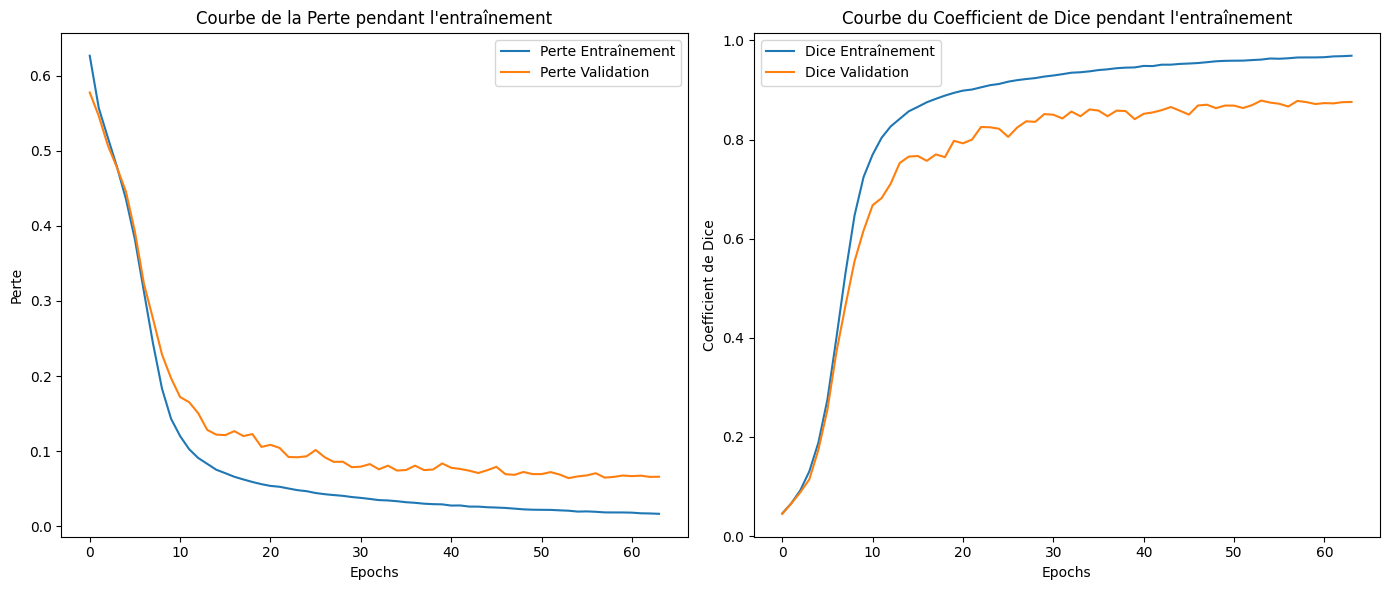

In [ ]:
# Tracer la courbe de la perte
plt.figure(figsize=(14, 6))

# Perte
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Perte Entraînement')
plt.plot(val_loss_history, label='Perte Validation')
plt.xlabel('Epochs')
plt.ylabel('Perte')
plt.title('Courbe de la Perte pendant l\'entraînement')
plt.legend()

# Coefficient de Dice
plt.subplot(1, 2, 2)
plt.plot(train_dice_history, label='Dice Entraînement')
plt.plot(val_dice_history, label='Dice Validation')
plt.xlabel('Epochs')
plt.ylabel('Coefficient de Dice')
plt.title('Courbe du Coefficient de Dice pendant l\'entraînement')
plt.legend()

# Afficher les graphiques
plt.tight_layout()
plt.show()


In [18]:
import torch
from torch.serialization import add_safe_globals


add_safe_globals([UNet, ConvBlock, EncoderBlock, DecoderBlock])


model = torch.load('/voletu/users/zhangnin/CODE/data/results_bce_dice_0.5/1.pt', weights_only=False)
model.eval()


from torchsummary import summary
summary(model, input_size=(1, 320, 320)) 


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 320, 320]             640
       BatchNorm2d-2         [-1, 64, 320, 320]             128
              ReLU-3         [-1, 64, 320, 320]               0
            Conv2d-4         [-1, 64, 320, 320]          36,928
       BatchNorm2d-5         [-1, 64, 320, 320]             128
              ReLU-6         [-1, 64, 320, 320]               0
         ConvBlock-7         [-1, 64, 320, 320]               0
         MaxPool2d-8         [-1, 64, 160, 160]               0
      EncoderBlock-9  [[-1, 64, 320, 320], [-1, 64, 160, 160]]               0
           Conv2d-10        [-1, 128, 160, 160]          73,856
      BatchNorm2d-11        [-1, 128, 160, 160]             256
             ReLU-12        [-1, 128, 160, 160]               0
           Conv2d-13        [-1, 128, 160, 160]         147,584
      BatchNorm2d-14    